!pip install git+https://github.com/EEA-sensors/parallel-non-linear-gaussian-smoothers.git@master

If running on Colab please run the command above.

### Imports

In [1]:
import jax.numpy as jnp
from jax.config import config

# from parsmooth.sequential import ekf, eks, ieks
# from parsmooth.sequential import ieks as seq_ieks
from parsmooth.models.bearings import get_data, make_parameters, plot_bearings
from parsmooth.parallel import ekf, eks, ieks
from parsmooth.utils import MVNormalParameters

# from jax import jit

config.update("jax_debug_nans", False)
config.update("jax_enable_x64", False)
config.update("jax_platform_name", "gpu")

### Input parameters

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

### Get parameters

In [3]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [4]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [5]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [6]:
initial_states = MVNormalParameters(jnp.zeros((T + 1, 5)), jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))

In [7]:
filtered = ekf(initial_guess,
               observations,
               transition_function,
               Q,
               observation_function,
               R,
               initial_states.mean)

In [8]:
smoothed = eks(transition_function, Q, filtered)


### And the iterated one

In [9]:
iterated_smoothed_trajectories = ieks(initial_guess,
                                      observations,
                                      transition_function,
                                      Q,
                                      observation_function,
                                      R,
                                      n_iter=15)

In [10]:
seq_iterated_smoothed_trajectories = ieks(initial_guess,
                                          observations,
                                          transition_function,
                                          Q,
                                          observation_function,
                                          R,
                                          None,
                                          n_iter=15,
                                          propagate_first=False)

### For comparison we can run the sequential iterated smoother too

### Plot the result

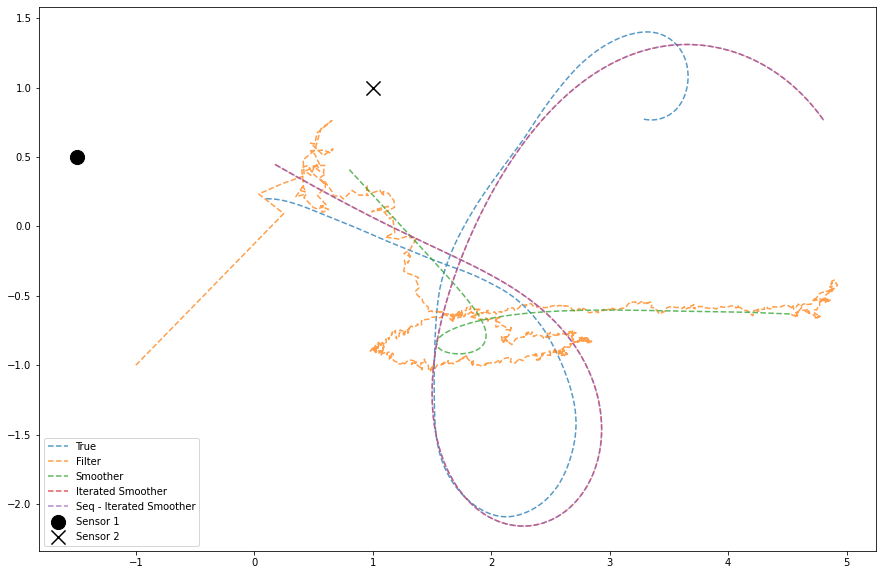

In [11]:
plot_bearings([true_states, filtered.mean, smoothed.mean, iterated_smoothed_trajectories.mean,
               seq_iterated_smoothed_trajectories.mean],
              ["True", "Filter", "Smoother", "Iterated Smoother", "Seq - Iterated Smoother"],
              s1, s2, figsize=(15, 10), quiver=False)

In [12]:
iterated_smoothed_trajectories.mean.shape

(1001, 5)

In [13]:
seq_iterated_smoothed_trajectories.mean.shape


(1000, 5)